# Quality Control prediction for incoming goods.
    
### **Grzegorz Kowalczyk**
#### 01/03/2024

* **1 Introduction**
* **2 Load and check data**
    * 2.1 Load data
    * 2.2 Data dictionary
    * 2.3 Data types, empty strings
    * 2.4 Outlier detection
    * 2.5 Check for null and missing values
* **4 Data preprocessing**
    * 4.1 Data cleaning
* **3 Feature analysis**
    * 3.1 Numerical values
    * 3.2 Categorical values
* **4 Filling missing Values**
    * 4.1 Age
* **5 Feature engineering**
    * 5.1 Name/Title
    * 5.2 Family Size
    * 5.3 Cabin
    * 5.4 Ticket
 
* **6 Scaling**
  
* **7 Modeling**
    * 6.1 Simple modeling
        * 6.1.1 Cross validate models
        * 6.1.2 Hyperparamater tunning for best models
        * 6.1.3 Plot learning curves
        * 6.1.4 Feature importance of the tree based classifiers
    * 6.2 Ensemble modeling
        * 6.2.1 Combining models
    * 6.3 Prediction
        * 6.3.1 Predict and Submit results

## 1. Introduction

In the context of mid-sized manufacturing enterprises, factories often engage in the production of a multitude of products, necessitating the procurement of numerous parts and components from a diverse array of international suppliers, often employing dual sourcing strategies.

This project endeavors to develop a predictive model, leveraging real-world production data, specifically focusing on aluminum LED profiles manufacturing, with the objective of accurately classifying incoming goods as either 'OK' or 'NOK' (not OK).

A robust working model, enhanced with additional refinements, holds the potential to provide valuable insights not only to quality assurance personnel but also to logistics professionals, aiding in supplier selection processes. Moreover, it can serve as a tool for research and development teams, facilitating the identification of product features during the design phase that mitigate the likelihood of faulty deliveries.


In [282]:
import pandas as pd
import numpy as np
import missingno
import seaborn as sns
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
# !pip install openpyxl

## 2. Load and check data

### 2.1 load data

In [283]:
df = pd.read_excel('../Github depo/QC_encoded_data.xlsx')

In [284]:
df.head()

,date,finish,delivered_pcs_pack,pack_weight_kg,OK_NOK,pcs_lenght_mm,quantity_pcs,overal_weight_kg,pcs_pck,name_e,drawing_no_e,shape_no_e,supplier_e
0,"13,01,2017",C-0,NaN,NaN,NOK,NaN,NaN,NaN,40.0,Regor,DR0,SH0,SU0
1,"13,01,2017",C-0,NaN,NaN,NOK,NaN,NaN,NaN,40.0,Procyon,DR1,SH1,SU0
2,"13,01,2017",C-0,NaN,NaN,NOK,NaN,NaN,NaN,40.0,Regor,DR0,SH0,SU0
3,"13,01,2017",C-0,NaN,NaN,NOK,NaN,NaN,NaN,40.0,Regor,DR0,SH0,SU0
4,"19,01,2017",C-0,NaN,NaN,NOK,NaN,NaN,NaN,40.0,Grus,DR2,SH2,SU1


In [285]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                6403 non-null   object 
 1   finish              6448 non-null   object 
 2   delivered_pcs_pack  4807 non-null   object 
 3   pack_weight_kg      2411 non-null   object 
 4   OK_NOK              6448 non-null   object 
 5   pcs_lenght_mm       4514 non-null   float64
 6   quantity_pcs        4514 non-null   object 
 7   overal_weight_kg    4488 non-null   float64
 8   pcs_pck             6350 non-null   float64
 9   name_e              6448 non-null   object 
 10  drawing_no_e        6448 non-null   object 
 11  shape_no_e          6448 non-null   object 
 12  supplier_e          6448 non-null   object 
dtypes: float64(3), object(10)
memory usage: 3.4 MB


Reorder the columns

In [286]:
new_order = ['OK_NOK','date', 'name_e', 'shape_no_e', 'drawing_no_e', 'finish', 'supplier_e', 'pcs_pck','delivered_pcs_pack', 'pack_weight_kg', 
       'pcs_lenght_mm', 'quantity_pcs', 'overal_weight_kg']

In [287]:
df = df[new_order]

In [288]:
df.shape

(6448, 13)

In [289]:
df.describe()

,pcs_pck,pcs_lenght_mm,overal_weight_kg
count,6350.000000,4514.000000,4488.000000
mean,38.541890,4078.381701,438.282907
std,22.971019,226.998957,226.470685
min,2.000000,1500.000000,0.000000
25%,20.000000,4050.000000,258.390000
50%,40.000000,4150.000000,450.357925
75%,40.000000,4150.000000,568.218000
max,100.000000,5100.000000,1702.413000


Describe function shows only 3 columns which means only those 3 are numeric, I will address this issue later on.

## 2.2 Data dictionary

* 0.   **OK_NOK**:
      This column contains a target label   
* 1.   **date**:
      Date of delivery
* 2.   **name_e**:
      This column consist of aluminum profile names
* 3.   **shape_no_e**:
      Number that defines shape of the aluminium profile.
      Shape itself dosn't describe the final product because many suppliers can deliver the same shape in many colours and at different lenghts
* 4.   **drawing_no_e**:
      Describes a shape and supplier but dosn't contain information about colours and different lenghts
* 5.   **finish**:
      Information about the colour of the profile
* 6.   **supplier_e**:
      Name of the supplier
* 7.   **pcs_pck**:
      Number of aluminium profiles that should be delivered in one package
* 8.   **delivered_pcs_pack**:
      Number of aluminium profiles that ware delivered in one package
* 9.   **pack_weight_kg**:
      Weight of one package
* 10.  **pcs_lenght_mm**:
      Lenght of the aluminium profiles
* 11.  **quantity_pcs**:
      How many pcs where delivered 
* 12.  **overal_weight_kg**:
      The overal weight delivered profiles

## 2.3 Data types, empty strings

### Since our target is binary classification we can map OK = 1 and NOK = 0

In [290]:
df['OK_NOK'] = df['OK_NOK'].map({'OK': 1, 'NOK': 0})

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OK_NOK              6448 non-null   int64  
 1   date                6403 non-null   object 
 2   name_e              6448 non-null   object 
 3   shape_no_e          6448 non-null   object 
 4   drawing_no_e        6448 non-null   object 
 5   finish              6448 non-null   object 
 6   supplier_e          6448 non-null   object 
 7   pcs_pck             6350 non-null   float64
 8   delivered_pcs_pack  4807 non-null   object 
 9   pack_weight_kg      2411 non-null   object 
 10  pcs_lenght_mm       4514 non-null   float64
 11  quantity_pcs        4514 non-null   object 
 12  overal_weight_kg    4488 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 655.0+ KB


 The columns:
* 'delivered_pcs_pack',
* 'pack_weight_kg',
* 'quantity_pcs'
  
   are mix of strings, numeric and nans that I need to handle first.

* **delivered_pcs_pack'**

In [292]:
delivered_pcs_vc = df['delivered_pcs_pack'].value_counts(dropna=False)


In [293]:
# Change the type of whole column to str

df['delivered_pcs_pack'] = df['delivered_pcs_pack'].astype(str)

# Filter out rows containing '40 / 60'
filtered_df = df[df['delivered_pcs_pack'].str.contains('40 / 60')]


In [294]:
#  Replace values, strip white spaces:

df['delivered_pcs_pack'] = df['delivered_pcs_pack'].replace(['20 SZT', 'BRAK', '-', '0', '40 / 60'], ['20', 'np.nan', 'np.nan', 'np.nan', '40']).str.strip()

# Change the whole column back to numeric

df['delivered_pcs_pack'] = pd.to_numeric(df['delivered_pcs_pack'], errors='coerce')


* **pack_weight_kg**

In [295]:
# Check for strings, nan etc, then convert to nummeric.
pack_weight_kg_vc = df['pack_weight_kg'].value_counts(dropna=False)
filtered_pack_weight_kg_vc = pack_weight_kg_vc[pack_weight_kg_vc<2]


In [296]:
df['pack_weight_kg'] =  pd.to_numeric(df['pack_weight_kg'], errors='coerce')
df['pack_weight_kg'] = df['pack_weight_kg'].round(decimals=1)
list(df['pack_weight_kg'].value_counts(dropna=False).index)

[nan,
 27.0,
 32.2,
 21.4,
 22.7,
 31.3,
 25.4,
 19.4,
 27.1,
 32.0,
 19.3,
 36.2,
 21.2,
 26.3,
 21.7,
 30.5,
 24.4,
 24.0,
 23.0,
 33.4,
 24.8,
 22.1,
 38.5,
 31.6,
 26.1,
 28.2,
 25.0,
 42.2,
 35.3,
 18.8,
 26.0,
 18.1,
 23.7,
 25.6,
 27.2,
 32.4,
 35.0,
 18.7,
 26.5,
 39.0,
 30.0,
 34.0,
 28.9,
 30.4,
 37.5,
 31.1,
 39.7,
 28.0,
 40.0,
 18.2,
 31.4,
 21.1,
 38.0,
 32.6,
 36.4,
 10.8,
 20.2,
 9.7,
 37.0,
 29.0,
 14.3,
 16.3,
 20.9,
 33.0,
 25.8,
 0.0,
 24.7,
 21.6,
 25.1,
 27.9,
 39.4,
 30.9,
 37.1,
 25.5,
 26.4,
 17.2,
 36.9,
 18.9,
 17.7,
 36.5,
 26.6,
 23.6,
 22.2,
 29.8,
 28.6,
 23.9,
 39.3,
 15.0,
 36.6,
 31.5,
 25.7,
 26.7,
 19.2,
 36.0,
 33.9,
 28.3,
 31.2,
 14.7,
 32.5,
 18.4,
 27.4,
 38.2,
 35.5,
 19.7,
 45.3,
 37.9,
 19.8,
 39.2,
 33.7,
 29.1,
 30.6,
 30.7,
 31.8,
 24.3,
 38.4,
 26.9,
 11.1,
 19.0,
 41.2,
 26.8,
 37.6,
 30.2,
 45.0,
 20.0,
 40.2,
 37.8,
 5.4,
 42.0,
 24.1,
 29.4,
 7.6,
 51.6,
 40.3,
 18.0,
 25.3,
 41.7,
 7.5,
 25.2,
 33.8,
 24.5,
 31.0,
 10.5,
 35.2,
 27.3

* **quantity_pcs**

In [297]:
quantity_pcs_vc = df['quantity_pcs'].value_counts(dropna=False)
quantity_pcs_vc

quantity_pcs
NaN       1934
600.0      115
360.0       94
400.0       86
1200.0      77
          ... 
594.0        1
1258.0       1
327.0        1
1260.0       1
2032.0       1
Name: count, Length: 1005, dtype: int64

In [298]:
df['quantity_pcs'] = pd.to_numeric(df['quantity_pcs'], errors='coerce')

In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OK_NOK              6448 non-null   int64  
 1   date                6403 non-null   object 
 2   name_e              6448 non-null   object 
 3   shape_no_e          6448 non-null   object 
 4   drawing_no_e        6448 non-null   object 
 5   finish              6448 non-null   object 
 6   supplier_e          6448 non-null   object 
 7   pcs_pck             6350 non-null   float64
 8   delivered_pcs_pack  4801 non-null   float64
 9   pack_weight_kg      2405 non-null   float64
 10  pcs_lenght_mm       4514 non-null   float64
 11  quantity_pcs        4513 non-null   float64
 12  overal_weight_kg    4488 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 655.0+ KB


## 2.4 Outlier detection

In [300]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from "pcs_pck", "pcs_lenght_mm", "overal_weight_kg", "quantity_pcs","pack_weight_kg","delivered_pcs_pack"
Outliers_to_drop = detect_outliers(df,2,["pcs_pck", "pcs_lenght_mm", "overal_weight_kg", "quantity_pcs","pack_weight_kg","delivered_pcs_pack"])

In [301]:
Outliers_to_drop

[]

Comment: It appears that there are no outliers in our data.

In [302]:
df.describe()

,OK_NOK,pcs_pck,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overal_weight_kg
count,6448.000000,6350.000000,4801.000000,2405.000000,4514.000000,4513.000000,4488.000000
mean,0.810174,38.541890,38.570142,27.548732,4078.381701,705.673942,438.282907
std,0.392194,22.971019,22.791827,10.219792,226.998957,591.612370,226.470685
min,0.000000,2.000000,0.250000,0.000000,1500.000000,0.000000,0.000000
25%,1.000000,20.000000,20.000000,22.100000,4050.000000,260.000000,258.390000
50%,1.000000,40.000000,40.000000,27.000000,4150.000000,525.000000,450.357925
75%,1.000000,40.000000,40.000000,32.200000,4150.000000,1000.000000,568.218000
max,1.000000,100.000000,250.000000,350.000000,5100.000000,5200.000000,1702.413000


### 2.5 Check for null and missing values

In [305]:
df.isnull().sum().sort_values(ascending=False)

pack_weight_kg        4043
overal_weight_kg      1960
quantity_pcs          1935
pcs_lenght_mm         1934
delivered_pcs_pack    1647
pcs_pck                 98
date                    45
OK_NOK                   0
name_e                   0
shape_no_e               0
drawing_no_e             0
finish                   0
supplier_e               0
dtype: int64

<Axes: >

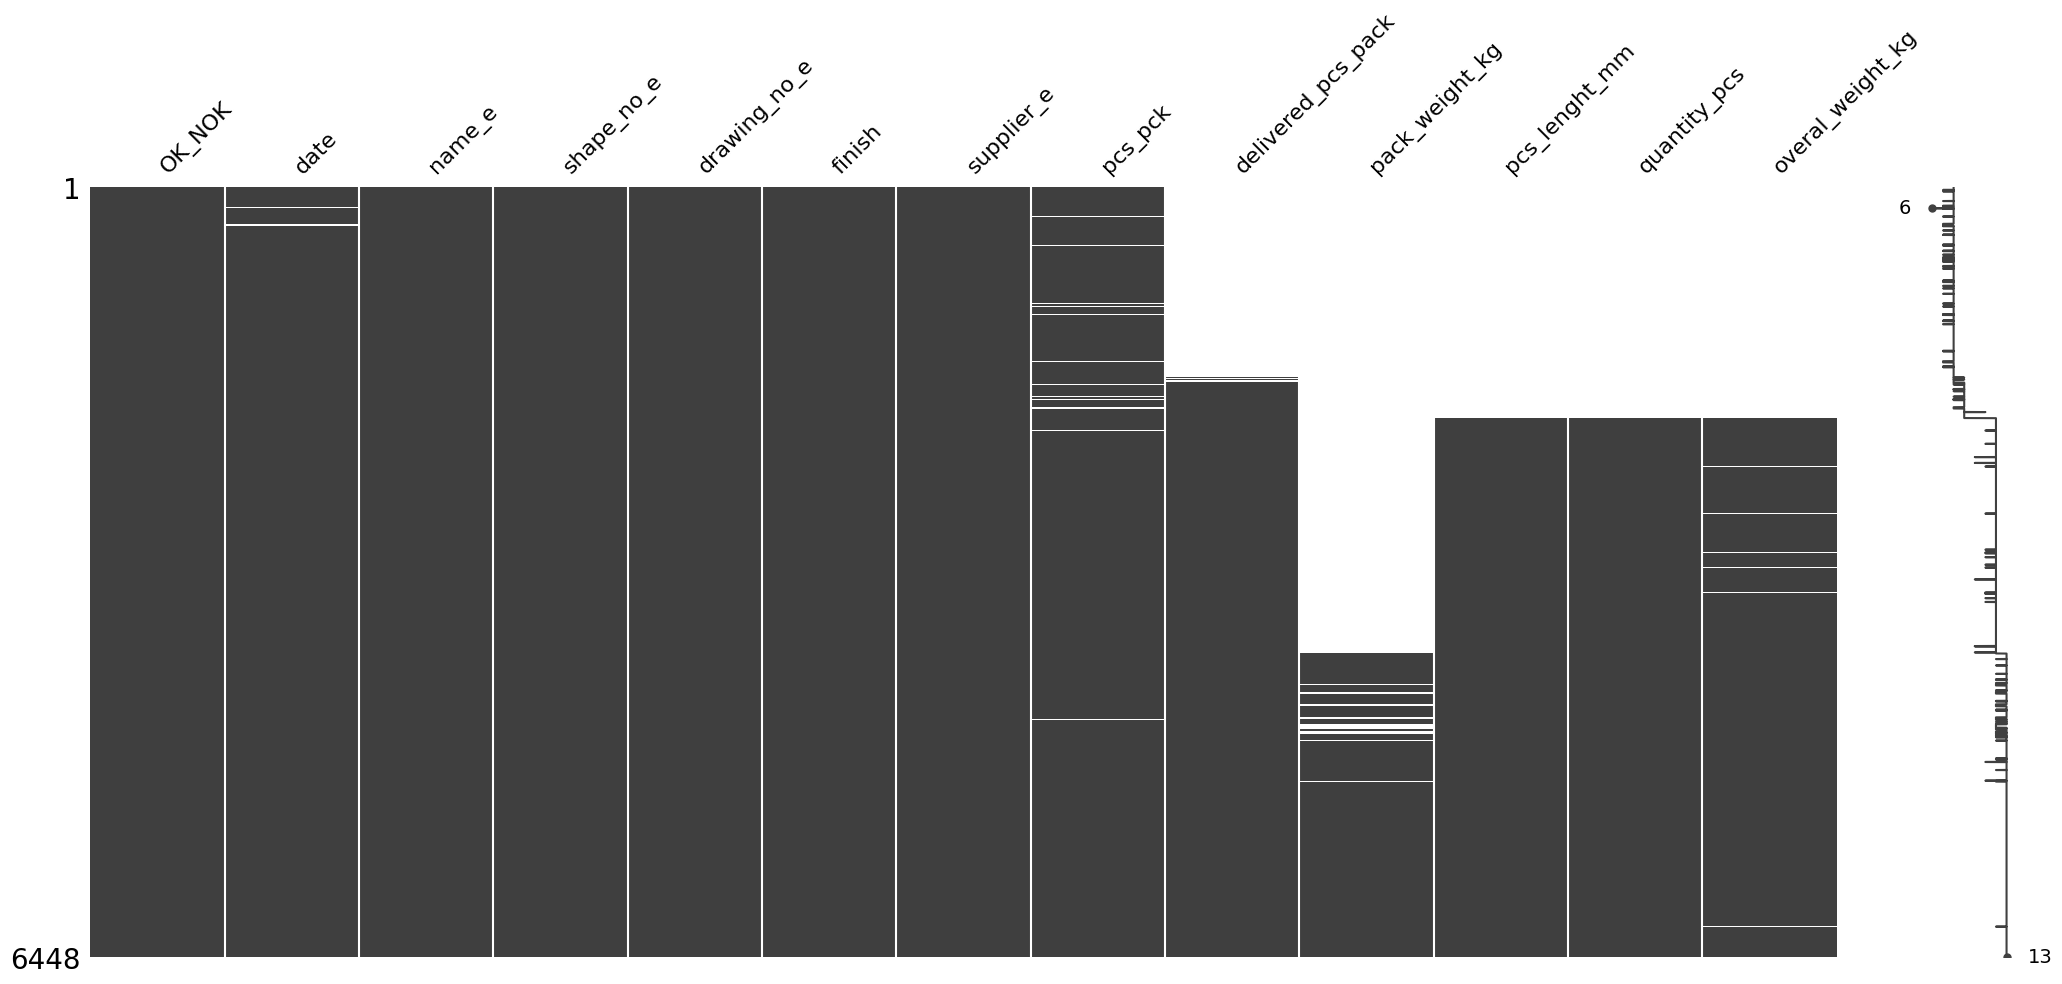

In [309]:
missingno.matrix(df)

<Axes: >

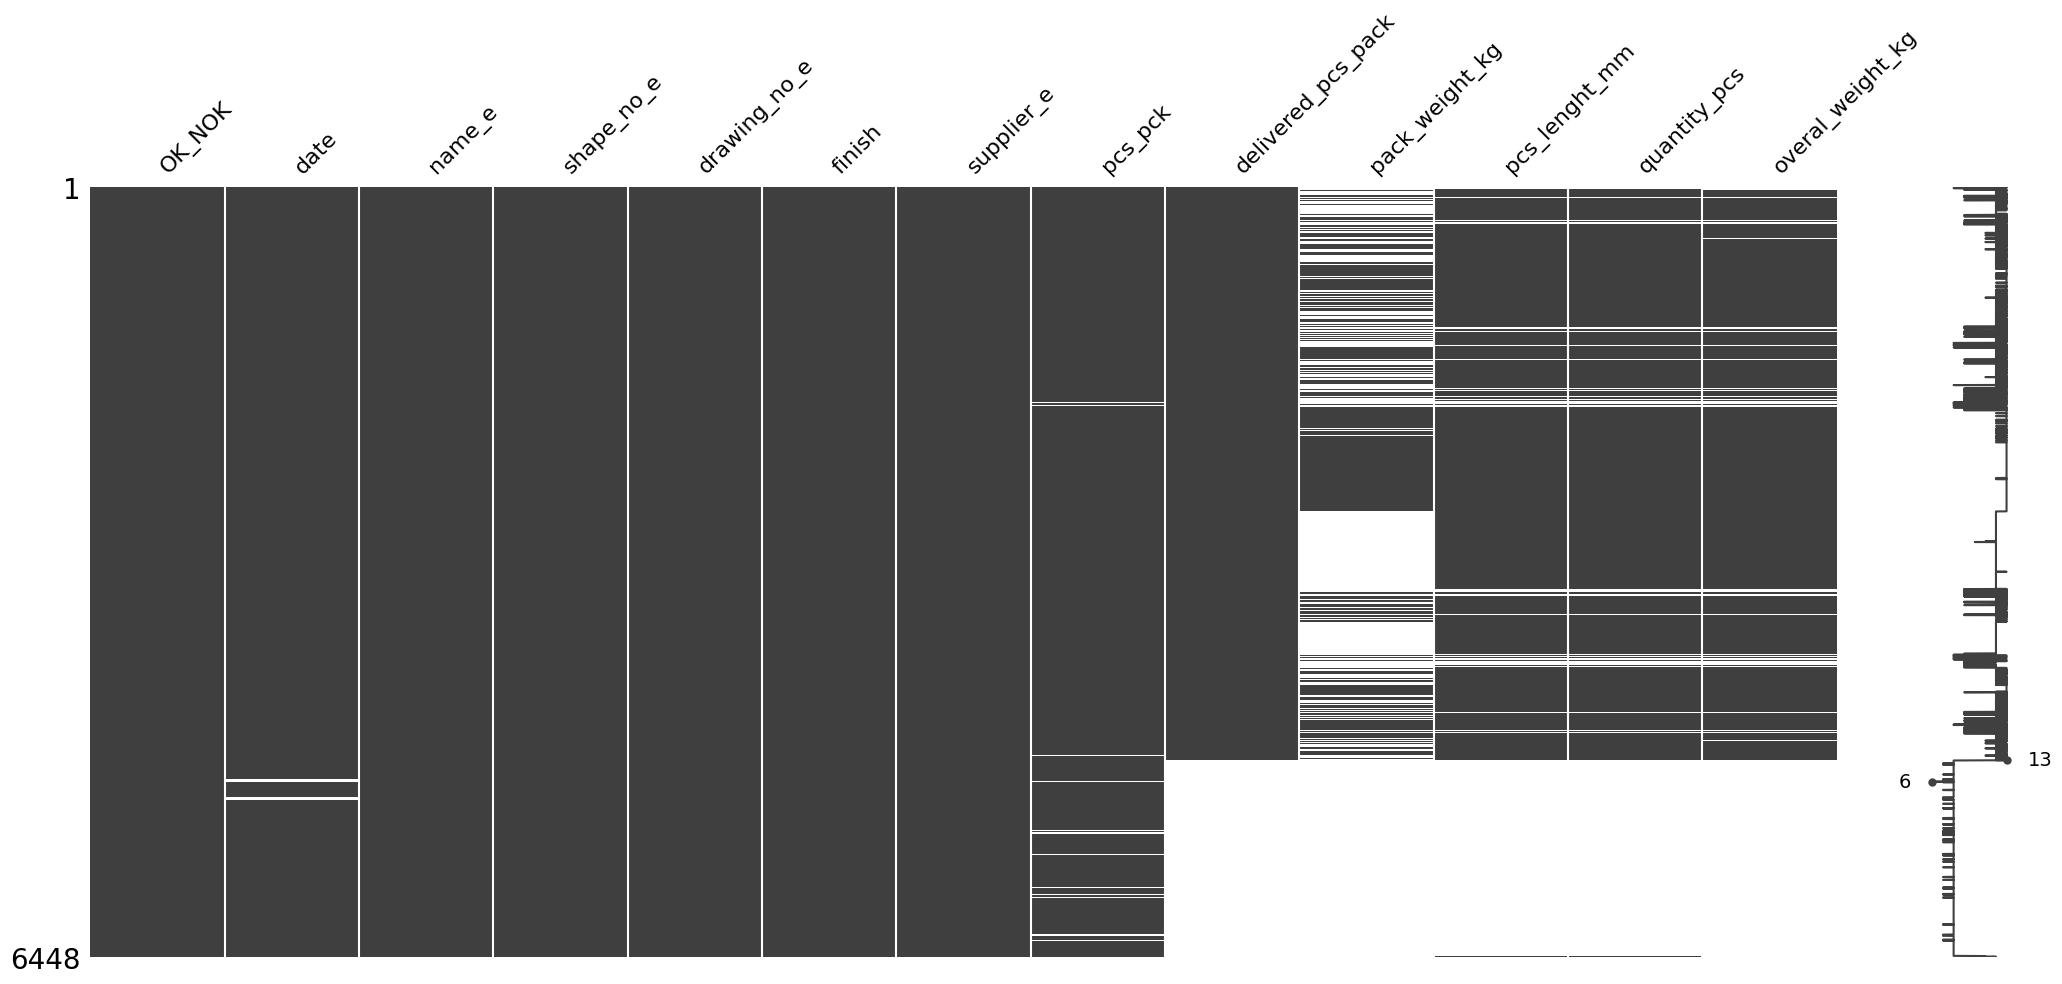

In [312]:
sorted_delivered_pcs_pack = df.sort_values('delivered_pcs_pack')
missingno.matrix(sorted_delivered_pcs_pack)

### 4. Data preprocesing

### 4.1 Data cleaning

In [313]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OK_NOK              6448 non-null   int64  
 1   date                6403 non-null   object 
 2   name_e              6448 non-null   object 
 3   shape_no_e          6448 non-null   object 
 4   drawing_no_e        6448 non-null   object 
 5   finish              6448 non-null   object 
 6   supplier_e          6448 non-null   object 
 7   pcs_pck             6350 non-null   float64
 8   delivered_pcs_pack  4801 non-null   float64
 9   pack_weight_kg      2405 non-null   float64
 10  pcs_lenght_mm       4514 non-null   float64
 11  quantity_pcs        4513 non-null   float64
 12  overal_weight_kg    4488 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 2.6 MB


In [315]:
df.date.iloc[-1]

datetime.datetime(2022, 9, 13, 0, 0)

In [322]:
df['is_str'] = df.date.apply(lambda x: True if isinstance(x, str) else False)
pd.set_option('display.max_columns', None)


   OK_NOK        date   name_e shape_no_e drawing_no_e finish supplier_e  \
0       0  13,01,2017    Regor        SH0          DR0    C-0        SU0   
1       0  13,01,2017  Procyon        SH1          DR1    C-0        SU0   
2       0  13,01,2017    Regor        SH0          DR0    C-0        SU0   
3       0  13,01,2017    Regor        SH0          DR0    C-0        SU0   
4       0  19,01,2017     Grus        SH2          DR2    C-0        SU1   

   pcs_pck  delivered_pcs_pack  pack_weight_kg  pcs_lenght_mm  quantity_pcs  \
0     40.0                 NaN             NaN            NaN           NaN   
1     40.0                 NaN             NaN            NaN           NaN   
2     40.0                 NaN             NaN            NaN           NaN   
3     40.0                 NaN             NaN            NaN           NaN   
4     40.0                 NaN             NaN            NaN           NaN   

   overal_weight_kg  is_str  
0               NaN    True  
1       

In [323]:
df.head(5)

,OK_NOK,date,name_e,shape_no_e,drawing_no_e,finish,supplier_e,pcs_pck,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overal_weight_kg,is_str
0,0,"13,01,2017",Regor,SH0,DR0,C-0,SU0,40.0,NaN,NaN,NaN,NaN,NaN,True
1,0,"13,01,2017",Procyon,SH1,DR1,C-0,SU0,40.0,NaN,NaN,NaN,NaN,NaN,True
2,0,"13,01,2017",Regor,SH0,DR0,C-0,SU0,40.0,NaN,NaN,NaN,NaN,NaN,True
3,0,"13,01,2017",Regor,SH0,DR0,C-0,SU0,40.0,NaN,NaN,NaN,NaN,NaN,True
4,0,"19,01,2017",Grus,SH2,DR2,C-0,SU1,40.0,NaN,NaN,NaN,NaN,NaN,True


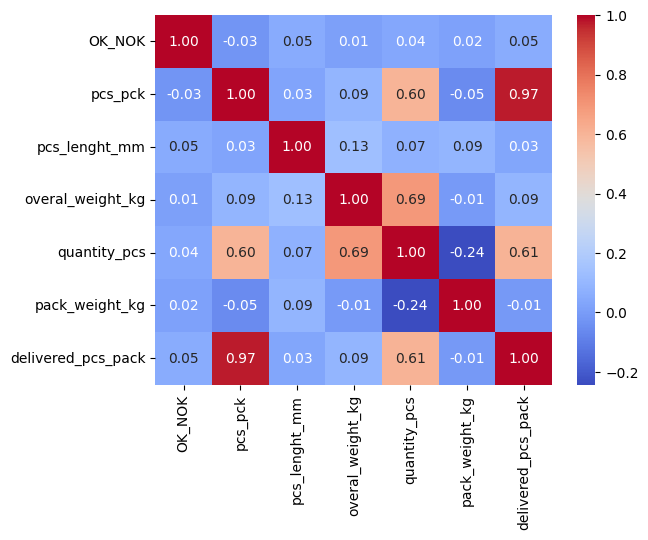

In [303]:
g = sns.heatmap(df[["OK_NOK","pcs_pck", "pcs_lenght_mm", "overal_weight_kg", "quantity_pcs","pack_weight_kg","delivered_pcs_pack"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")